In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from scipy.ndimage import convolve

import matplotlib.pyplot as plt

from pathlib import Path
from uavsar_pytools.convert.tiff_conversion import read_annotation

In [2]:
slc_dir = Path('~/scratch/data/uavsar/slcs').expanduser()

In [102]:
class SLC():

    def __init__(self, fp):

        # get metadata from slc filename
        #https://uavsar.jpl.nasa.gov/science/documents/stack-format.html
        site_name, line_id, flight_id, data_counter, acquisition_date, band_steering_pol,\
            stack_number, baseline_correct, segment, pixel_factor = fp.stem.split('_')
        
        # pull out band, steering angle, and polarization
        band, steering, polarization = band_steering_pol[0], band_steering_pol[1:4], band_steering_pol[4:]

        # snag segment without s for parsing metadata
        segment = int(segment.strip('s'))

        # get slc data as numpy array
        slc_arr = np.fromfile(fp, dtype = np.complex64)
        slc_arr = np.where(slc_arr != 0, slc_arr, np.nan+np.nan*1j)
        ann = read_annotation(next(fp.parent.glob(f"{'_'.join(fp.stem.split('_')[:6])}*.ann")))

        llh = np.fromfile(next(slc_dir.glob(f'*_s{segment}_*.llh')), dtype = np.float32)
        lat, long, height = llh[::3], llh[1::3], llh[2::3]
        lkv = np.fromfile(next(slc_dir.glob(f'*_s{segment}_*.lkv')), dtype = np.float32)
        x, y, z = lkv[::3], lkv[1::3], lkv[2::3]

        nrows = ann[f'slc_{segment}_{pixel_factor}_phase.set_rows']['value'] # n rows
        ncols = ann[f'slc_{segment}_{pixel_factor}_phase.set_cols']['value'] # n cols
        start_azimuth = ann[f'slc_{segment}_{pixel_factor}_phase.row_addr']['value'] # m @ first pixel
        azimuth_spacing = ann[f'slc_{segment}_{pixel_factor}_phase.row_mult']['value'] # m / pixel
        start_range = ann[f'slc_{segment}_{pixel_factor}_phase.col_addr']['value'] # m from plane to first pixel
        range_spacing = ann[f'slc_{segment}_{pixel_factor}_phase.col_mult']['value'] # m / pixel
        corners = {}
        for c in range(1, 5):
            corners[c] = ann[f'segment {segment} data approximate corner {c}'] # approximate lat lon of corners
        start = ann['start time of acquisition'] # start of flight

        self.slc = slc_arr.reshape(nrows, ncols)
        llh_rows, llh_cols = ann[f'llh_{segment}_2x8.set_rows']['value'], ann[f'llh_{segment}_2x8.set_cols']['value']
        self.lat = lat.reshape(llh_rows, llh_cols)
        self.long = long.reshape(llh_rows, llh_cols)
        self.dem = height.reshape(llh_rows, llh_cols)
        lkv_rows, lkv_cols = ann[f'lkv_{segment}_2x8.set_rows']['value'], ann[f'lkv_{segment}_2x8.set_cols']['value']
        self.lkv_x = x.reshape(lkv_rows, lkv_cols)
        self.lkv_y = y.reshape(lkv_rows, lkv_cols)
        self.lkv_z = z.reshape(lkv_rows, lkv_cols)
        self.ann = ann
        self.nrows = nrows
        self.ncols = ncols
        self.start_azimuth = start_azimuth
        self.azimuth_spacing = azimuth_spacing
        self.start_range = start_range
        self.range_spacing = range_spacing
        self.corners = corners
        self.polarization = polarization
        self.date = start
    
    def calculate_incidence_angle(self):
        # https://stackoverflow.com/questions/53350391/surface-normal-calculation-from-depth-map-in-python
        d_im = self.dem
        x_scaling = self.range_spacing
        y_scaling = self.azimuth_spacing
        zy, zx = np.gradient(d_im)
        normal = np.dstack((-zx/x_scaling, -zy/y_scaling, np.ones_like(d_im)))
        n = np.linalg.norm(normal, axis=2)
        normal[:, :, 0] /= n
        normal[:, :, 1] /= n
        normal[:, :, 2] /= n

        mag = (self.lkv_x**2 + self.lkv_y**2 + self.lkv_z**2)**0.5
        self.lkv_mag = mag
        rls = np.zeros_like(d_im)
        rls = np.repeat(np.expand_dims(rls, axis = 2), 3, axis = 2)
        rls = np.dstack((self.lkv_x, self.lkv_y, self.lkv_z))
        rls[:,:, 0] /= mag
        rls[:,:, 1] /= mag
        rls[:,:, 2] /= mag

        inc = np.zeros(d_im.shape)
        for i in range(rls.shape[0]):
            for j in range(rls.shape[1]):
                inc[i, j] = np.arccos(np.dot(-normal[i, j], rls[i, j]))
        self.inc = inc

from numpy.lib.stride_tricks import sliding_window_view
# try:
#     import cupy as cp
#     CUPY = True
# except ModuleNotFoundError:
#     CUPY = False

def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2)),
                  mode = 'constant')

def goldstein(arr, alpha = 0.2, window_size = 32):
    """
    Apply goldstein filter to complex numpy arr

    Args:
    arr: Complex numpy array of phases
    alpha: degree of filtering. Ranges from no filter @ 0 to 1/2 bandwidth @ 1
    window_size: size of window in samples to apply filter over

    Returns:
    filtered: filtered complex numpy array
    """
    CUPY = False
    if CUPY:
        Z = cp.fft.fft2(sliding_window_view(arr, (window_size, window_size)))
    else:
        Z = np.fft.fft2(sliding_window_view(arr, (window_size, window_size)))
    psd_sc = np.abs(Z)**alpha
    Z = Z * psd_sc
    if CUPY:
        x = cp.fft.ifft2(Z)
    else:
        x = np.fft.ifft2(Z)


    wgts = (1 - np.abs(2*(np.arange(window_size) - window_size/2)/(window_size+1))) / (window_size*window_size)
    filtered = np.average(np.average(x, axis = -1, weights= wgts), axis= -1, weights = wgts)

    filtered = to_shape(filtered, arr.shape)

    return filtered

In [10]:
slcs = []
for fp in slc_dir.glob('*_s1_*.slc'):
    slc = SLC(fp)
    slc.calculate_incidence_angle()
    slcs.append(slc)

In [37]:
def make_interferogram(u1, u2):

    # get wrapped phase
    int = np.angle(u1*u2.conj())

    # get coherence
    # https://ceur-ws.org/Vol-1814/paper-12.pdf
    kernel = [[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]
    n1 = np.abs(convolve(u1*u2.conj(), kernel, mode= 'constant'))
    d1 = convolve(np.abs(u1)**2, kernel, mode = 'constant')
    d2 = convolve(np.abs(u2.conj())**2, kernel, mode = 'constant')
    coherence = n1 / (d1 * d2)**0.5

    return int, coherence

In [38]:
int, coherence = make_interferogram(slcs[0].slc, slcs[1].slc)

In [ ]:
# wrapped = u1*u2.conj()
# sub = wrapped#[:10000]
# sub_coherence = coherence#[:10000]
# sub[(np.isnan(sub)) | (~np.isfinite(sub))] = 0*0*1j
# sub_coherence[(np.isnan(sub_coherence)) | (~np.isfinite(sub_coherence))] = 0
# filename = Path("~/snaphu/data/232_20210115_20210120.int.dat").expanduser()
# with open(filename, mode='wb') as fileobj:
#     sub.astype(np.complex64).tofile(fileobj)

# filename = Path("~/snaphu/data/232_20210115_20210120.cor.dat").expanduser()
# with open(filename, mode='wb') as fileobj:
#     sub_coherence.astype(np.float32).tofile(fileobj)

SNAPHU Args:

tile = --tile 3 4 30 30 # 3 x 4 tiels with 30  pixel overlap

-o filepath of outfile
-c corr file


In [39]:
from skimage.measure import block_reduce
slc_ds = block_reduce(slcs[0].slc*slcs[1].slc.conj(), block_size = (8,2), func = np.mean, cval = np.nan)
coherence_ds = block_reduce(coherence, block_size = (8,2), func = np.mean, cval = np.nan)

In [40]:
slc_ds[(np.isnan(slc_ds)) | (~np.isfinite(slc_ds)) | (coherence_ds<0.3)] = 0*0*1j
coherence_ds[(np.isnan(coherence_ds)) | (~np.isfinite(coherence_ds))] = 0
filename = Path("~/snaphu/data/232_20210115_20210120_2x8.int.dat").expanduser()
with open(filename, mode='wb') as fileobj:
    slc_ds.astype(np.complex64).tofile(fileobj)

filename = Path("~/snaphu/data/232_20210115_20210120_2x8.cor.dat").expanduser()
with open(filename, mode='wb') as fileobj:
    coherence_ds.astype(np.float32).tofile(fileobj)

In [41]:
from phase_o_matic.utils import regrid_twoD_coords

def make_DA(data, lat, long):
    DA = xr.DataArray(data, 
             coords = {
                 "lat": (("y","x"), lat),
                 "lon": (("y","x"), long)
             },
             dims = ["y","x"])
    
    DA = regrid_twoD_coords(DA)

    return DA

In [42]:
# da = make_DA(np.angle(slc_ds), slc.lat, slc.long)

In [43]:
unw = np.fromfile(Path("/bsuhome/zacharykeskinen/snaphu/data/test_defo_full_2x8.out").expanduser(), dtype = np.float32)

In [44]:
unw_masked = np.where(coherence_ds > 0.2, unw.reshape(slc.lat.shape), np.nan)

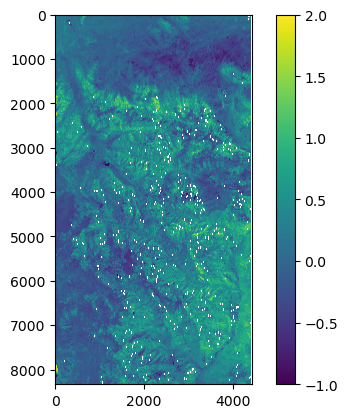

In [50]:
plt.imshow(unw_masked, vmin = -1, vmax = 2)
plt.colorbar()

In [49]:
slcs[0].calculate_incidence_angle()

In [51]:
im = slcs[0]

In [57]:
def topographic_phase(dem, slant_distance, spatial_baseline, incidence_angle, wavelength = 0.238403545):
    return 4 * np.pi * spatial_baseline * dem / (slant_distance* wavelength * np.sin(incidence_angle))

In [99]:
im2 = slcs[1]
im2.mag = (im2.lkv_x**2 +im2.lkv_y**2 +im2.lkv_z**2)**0.5

In [100]:
tp = topographic_phase(im.dem - np.nanmean(im.dem), im2.mag - im.mag, 1, im.inc)
np.nanquantile(tp, [0.05, 0.95])

/tmp/ipykernel_18500/773059128.py:2: RuntimeWarning: invalid value encountered in divide
  return 4 * np.pi * spatial_baseline * dem / (wavelength * np.sin(incidence_angle))


array([0., 0.])

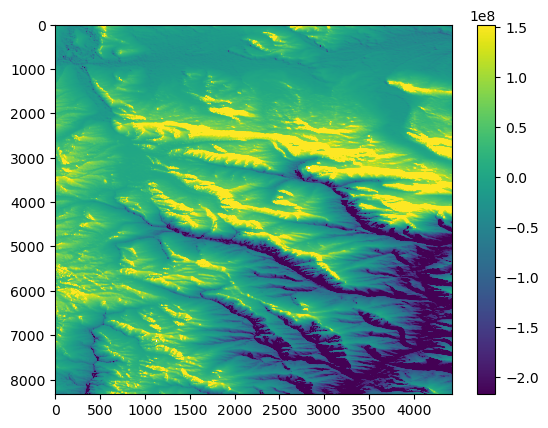

In [92]:
plt.imshow(tp, aspect = 'auto', vmin = -2.16810269e+08, vmax =  1.52569258e+08)
plt.colorbar()